In [1]:
import numpy as np

import tensorflow as tf
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Conv3D, ConvLSTM2D, BatchNormalization
from keras.models import Sequential

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

zip_train = zipfile.ZipFile('/content/drive/MyDrive/Colab_Notebooks/circular_motion.zip','r')
zip_train.extractall('/tmp')
zip_train.close()


GOOD. MINIMIZE DATA AND EPOCHS FOR NOW



In [9]:
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import random_noise

n_samples = 600
total_frames = 60
row = 128
col = 128
step = 2 #skip every other image to try to prevent subsequent frames looking too similar
n_frames = int(total_frames/step)
dataset = np.zeros((n_samples, n_frames, row, col), dtype=float) #define dataset array type

source_directory = "/tmp/circular_motion"

for folder_num in range(n_samples):
    folder_path = source_directory + "/" + str(folder_num)
    if os.path.isdir(folder_path):
        for idx in range(0,total_frames,step):
            file_path = folder_path + "/" + str(idx) + ".png"
            img = cv2.imread(file_path)

            # resize the image to 128x128
            img_resized = cv2.resize(img, (row, col))

            #GOING TO REMOVE BACKGROUND

            hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)

            # define the range of blue color in HSV (ball is blue)
            lower_blue = np.array([100, 50, 50])
            upper_blue = np.array([130, 255, 255])

            # create a mask for the blue color
            mask = cv2.inRange(hsv, lower_blue, upper_blue)

            # invert mask to get the background
            inverted_mask = cv2.bitwise_not(mask)

            # set all pixels to 0 where the mask is between threshold (background)
            img_processed = cv2.bitwise_and(img_resized, img_resized, mask=inverted_mask)

            # Convert the processed image to grayscale
            img_processed_gray = cv2.cvtColor(img_processed, cv2.COLOR_BGR2GRAY)

            # ADD SALT AND PEPPER NOISE
            img_noisy = random_noise(img_processed_gray, mode='s&p', amount=0.05)

            # NORMALIZE
            img_noisy = img_noisy / 255.0

            # Assign the processed image to the dataset
            dataset[folder_num][int(idx/step)] = img_noisy

In [10]:
dataset = dataset[..., np.newaxis]
dataset.shape

(600, 30, 128, 128, 1)

In [11]:
X = dataset[:, 0:n_frames-1, :, :]
y = dataset[:, 1:n_frames, :, :]
print(X.shape)

(600, 29, 128, 128, 1)


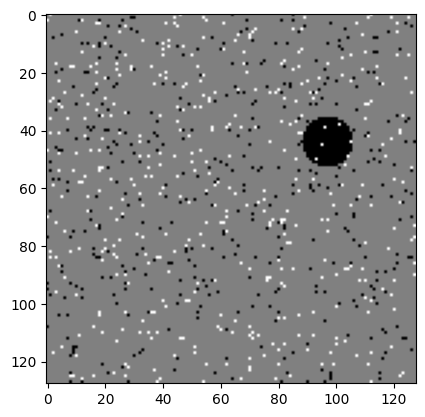

In [12]:
# Show example image
plt.imshow(dataset[79][0], cmap='gray')
plt.show()

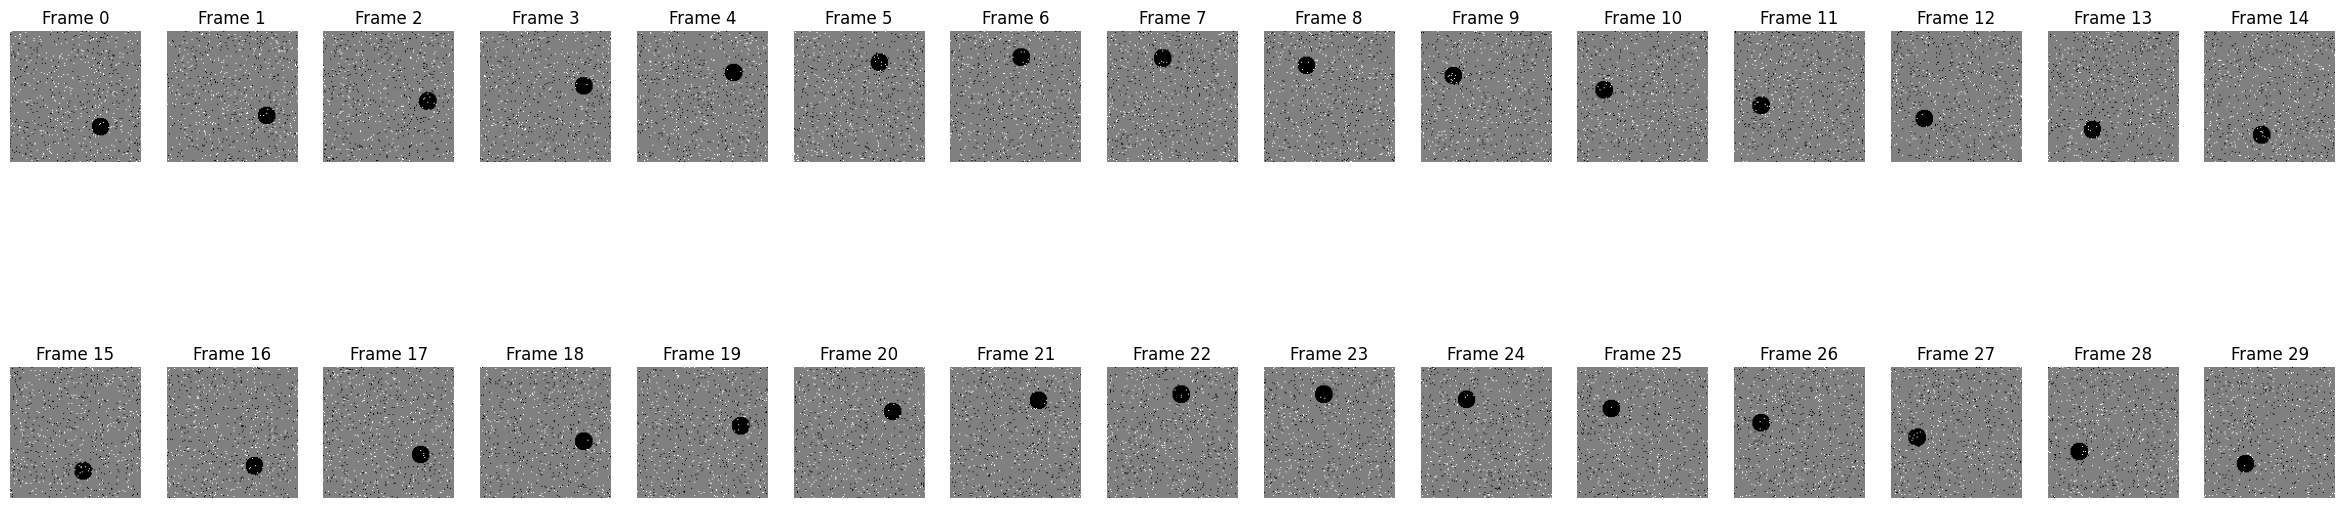

In [13]:
import math

images = dataset.shape[1]
half_images = math.ceil(images / 2)

# create two rows of subplots
fig, axes = plt.subplots(2, half_images, figsize=(images, 8))

# plot the top row
for idx in range(half_images):
    ax = axes[0, idx]
    ax.imshow(dataset[1][idx], cmap='gray')
    ax.set_title(f"Frame {idx}")
    ax.axis("off")

# plot the bottom row
for idx in range(half_images, images):
    ax = axes[1, idx - half_images]  # adjust the index for the second row
    ax.imshow(dataset[1][idx], cmap='gray')
    ax.set_title(f"Frame {idx}")
    ax.axis("off")

plt.show()


In [15]:
from keras.layers import Attention, GlobalAveragePooling3D, concatenate, Reshape, Flatten, Conv2DTranspose, TimeDistributed
from keras.models import Sequential, Model
from keras.layers import ConvLSTM2D, BatchNormalization, Conv3D, Input, Dense
import keras

# make sequential model
seq = Sequential()

# add attention layer to determine important parts of the input
input_layer = Input(shape=(None, 128, 128, 1))
attention = Attention(use_scale=True)([input_layer, input_layer])
attended_input = keras.layers.multiply([input_layer, attention])

# apply ConvLSTM directly on the attended input
#4 layers of ConvLSTM and BatchNormalization to process image data
seq.add(ConvLSTM2D(filters=128, kernel_size=(3, 3),
                   padding='same', return_sequences=True, input_shape=(None, 128, 128, 1)))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

# TimeDistributed apply Conv2DTranspose (upsample to get proper dimensions) to each time step/sequential frame individually applied to attended_input
# after it's gone through the ConvLSTM+BatchNormalization processing
reconstructed_output = TimeDistributed(Conv2DTranspose(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same'))(seq(attended_input))


# create the model
model = Model(inputs=input_layer, outputs=reconstructed_output)

# compile model
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])


Epoch 1/10
1/1 [==============================] - 0s 149ms/step


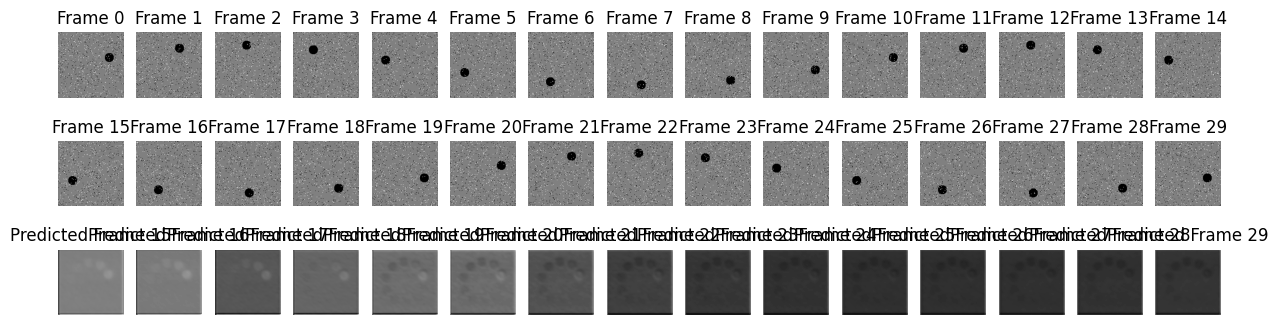

90/90 [==============================] - 63s 627ms/step - loss: 0.7062 - accuracy: 0.0365 - val_loss: 0.7046 - val_accuracy: 0.0334 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - 0s 151ms/step


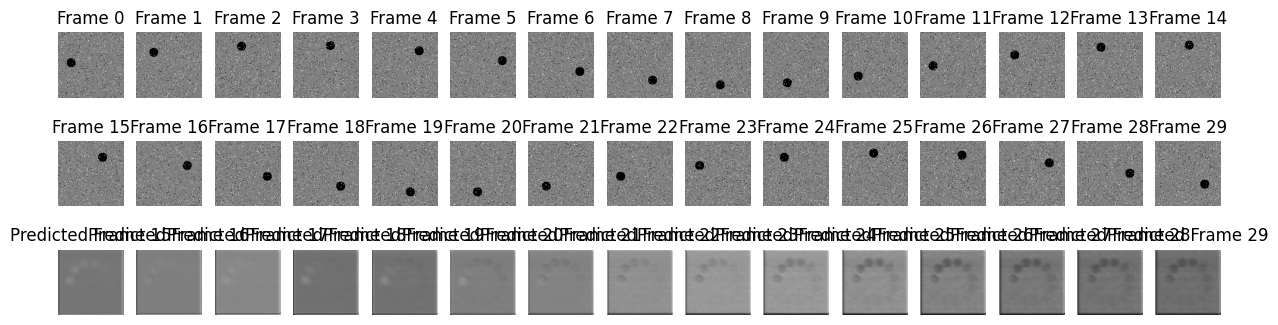

90/90 [==============================] - 54s 599ms/step - loss: 0.6931 - accuracy: 0.0387 - val_loss: 0.6971 - val_accuracy: 0.0320 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - 0s 151ms/step


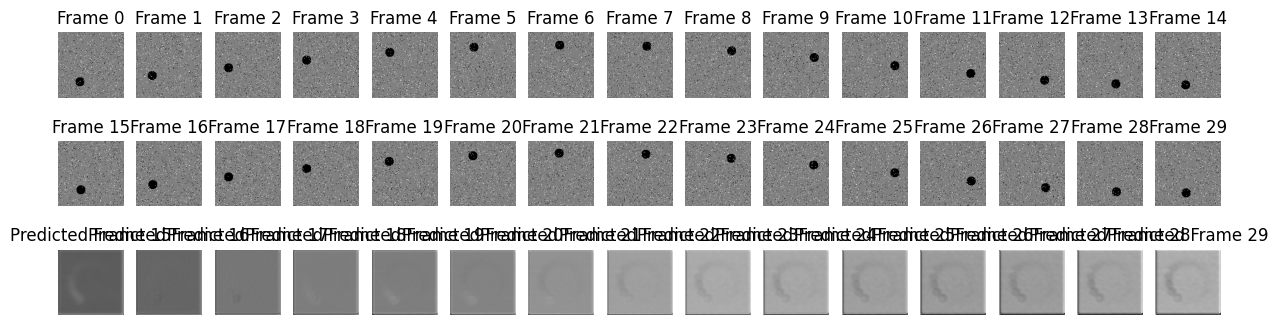

90/90 [==============================] - 53s 595ms/step - loss: 0.6931 - accuracy: 0.0388 - val_loss: 0.6959 - val_accuracy: 0.0332 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - 0s 151ms/step


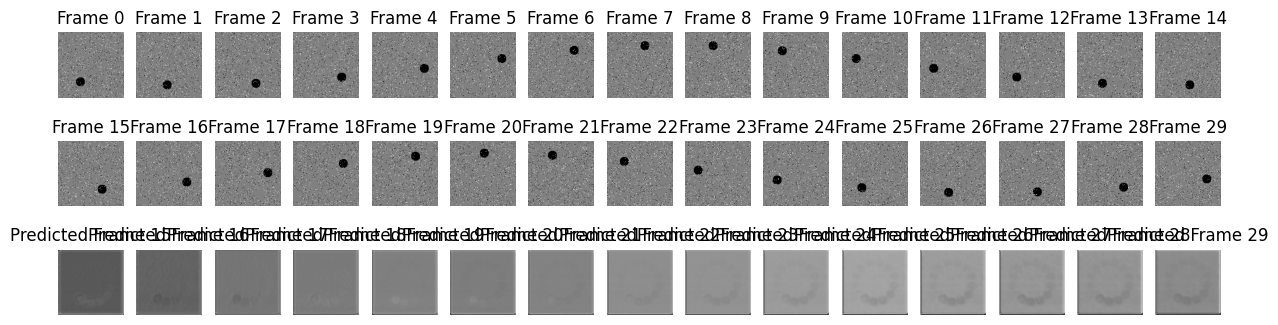

90/90 [==============================] - 54s 601ms/step - loss: 0.6930 - accuracy: 0.0387 - val_loss: 0.6954 - val_accuracy: 0.0341 - lr: 0.0010
Epoch 5/10
1/1 [==============================] - 0s 150ms/step


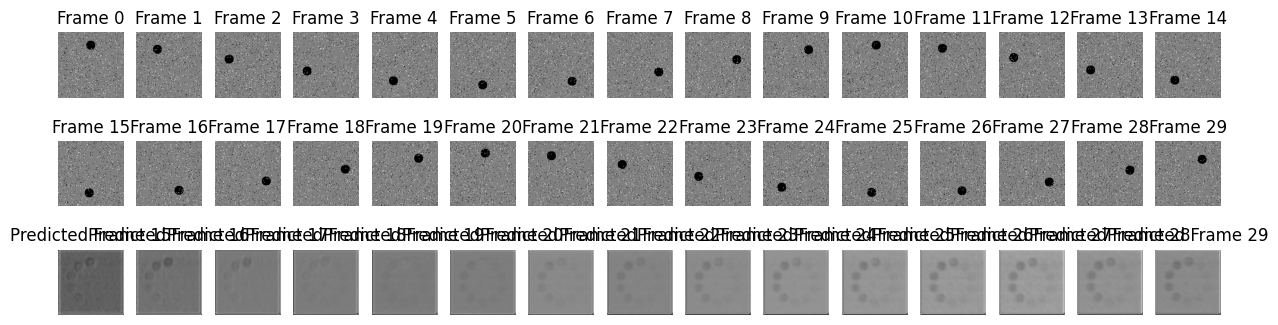

90/90 [==============================] - 54s 602ms/step - loss: 0.6930 - accuracy: 0.0385 - val_loss: 0.6946 - val_accuracy: 0.0361 - lr: 0.0010
Epoch 6/10
1/1 [==============================] - 0s 151ms/step


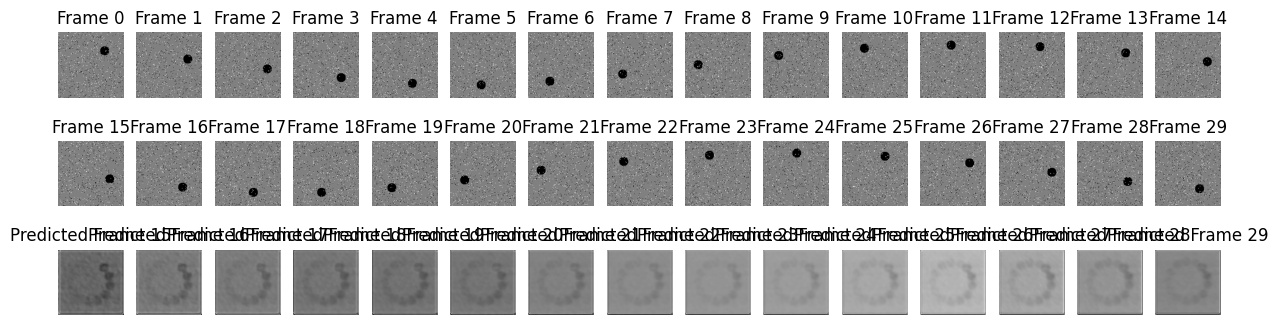

90/90 [==============================] - 54s 597ms/step - loss: 0.6930 - accuracy: 0.0386 - val_loss: 0.6939 - val_accuracy: 0.0378 - lr: 0.0010
Epoch 7/10
1/1 [==============================] - 0s 150ms/step


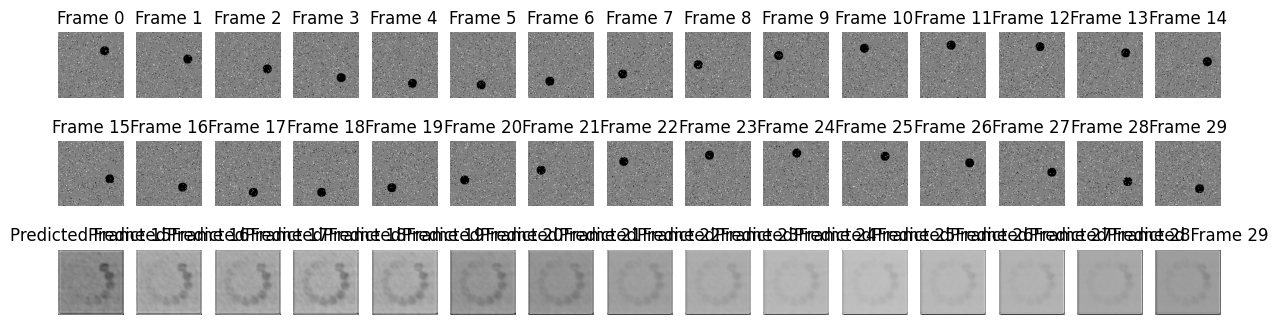

90/90 [==============================] - 54s 602ms/step - loss: 0.6930 - accuracy: 0.0384 - val_loss: 0.6937 - val_accuracy: 0.0345 - lr: 0.0010
Epoch 8/10
1/1 [==============================] - 0s 152ms/step


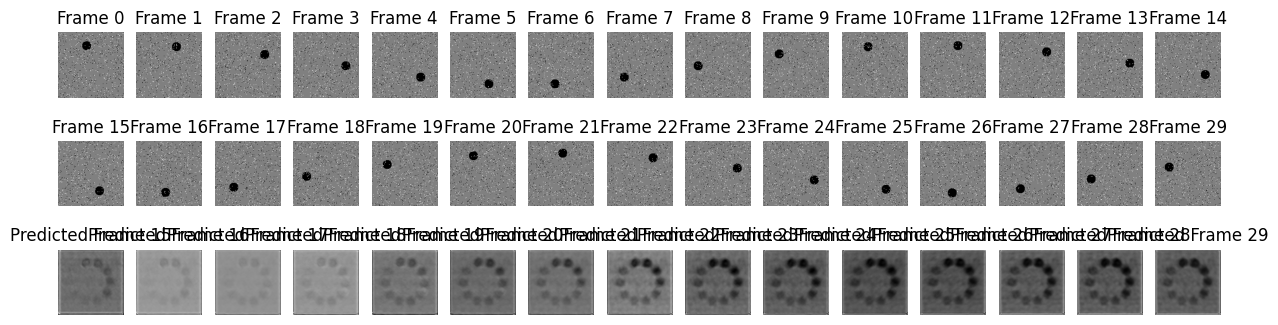

90/90 [==============================] - 54s 598ms/step - loss: 0.6930 - accuracy: 0.0385 - val_loss: 0.6934 - val_accuracy: 0.0382 - lr: 0.0010
Epoch 9/10
1/1 [==============================] - 0s 151ms/step


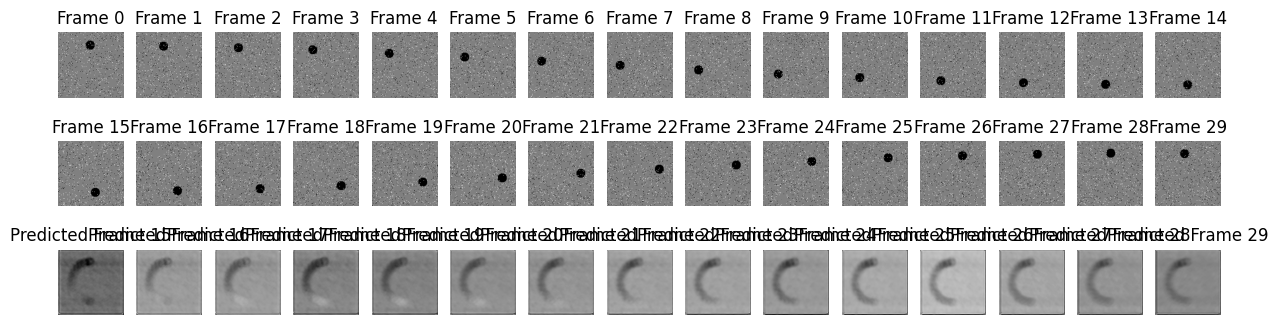

90/90 [==============================] - 54s 603ms/step - loss: 0.6930 - accuracy: 0.0386 - val_loss: 0.6932 - val_accuracy: 0.0369 - lr: 0.0010
Epoch 10/10
1/1 [==============================] - 0s 150ms/step


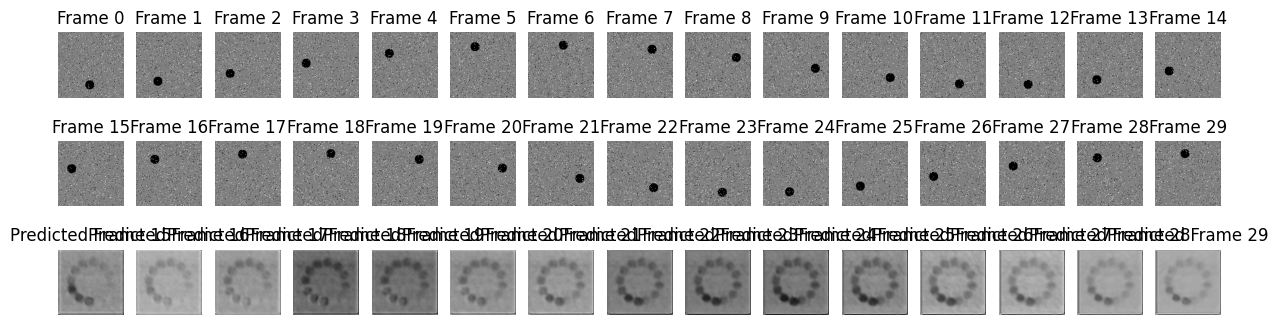

90/90 [==============================] - 54s 598ms/step - loss: 0.6930 - accuracy: 0.0386 - val_loss: 0.6932 - val_accuracy: 0.0373 - lr: 0.0010


In [17]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
import math

images = dataset.shape[1]
half_imgs = math.ceil(images / 2)

#set patience levels for early stopping and learning rate reduction
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

epochs = 10
batch_size = 1

class PrintPredictionCallback(Callback):
    def __init__(self, dataset, half_imgs):
        super(PrintPredictionCallback, self).__init__()
        self.dataset = dataset
        self.half_imgs = half_imgs

    def on_epoch_end(self, epoch, logs=None):
        # select a random example from the validation dataset.
        example = dataset[random.randrange(501, 599)]

        # pick the first/last 15 frames from the example.
        frames = example[:half_imgs, ...]  # first 15 (get concatenated to)
        original_frames = example[half_imgs:, ...]  # last 15
        ogog_frames = example[:half_imgs, ...]  # first 15, unadulterated

        # predict a next 15 frames
        for _ in range(half_imgs):
            # extract model's prediction and process it
            new_prediction = model.predict(np.expand_dims(frames, axis=0))
            new_prediction = np.squeeze(new_prediction, axis=0)
            predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

            # add to set of prediction frames for next prediction
            frames = np.concatenate((frames, predicted_frame), axis=0)

        # construct a figure. Top row = original first 15
        # middle row = ground truth last 15 frames
        #bottom row = predicted last 15 frames
        fig, axes = plt.subplots(3, half_imgs, figsize=(half_imgs, 4))

        for idx, ax in enumerate(axes[0]):
            ax.imshow(ogog_frames[idx], cmap='gray')
            ax.set_title(f"Frame {idx}")
            ax.axis("off")

        for idx, ax in enumerate(axes[1]):
            ax.imshow(original_frames[idx], cmap='gray')
            ax.set_title(f"Frame {idx + half_imgs}")
            ax.axis("off")

        # Plot the new frames.
        new_frames = frames[half_imgs:, ...]
        for idx, ax in enumerate(axes[2]):
            ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
            ax.set_title(f"Predicted Frame {idx + half_imgs}")
            ax.axis("off")

        # display the figure.
        plt.show()

# create instance of custom callback function
print_prediction_callback = PrintPredictionCallback(dataset, half_imgs)

# start training model. Use the callback during to print images and get statistic
model.fit(X[:100], y[:100], batch_size=1,
        epochs=epochs, validation_split=0.1, callbacks=[early_stopping, reduce_lr, print_prediction_callback])


In [26]:
import random
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap

import math

samples = dataset.shape[0]

half_imgs = int(dataset.shape[1] / 2) #assume half total samples is 15 for comments

with PdfPages('/output_frames_circle_attention.pdf') as pdf:
    for i in range(30):
        # select a random example from the validation dataset.
        example = dataset[random.randrange(501, 599)]

        # pick the first/last 15 frames from the example.
        frames = example[:half_imgs, ...]  # first 15 (get concatenated to)
        original_frames = example[half_imgs:, ...]  # last 15
        ogog_frames = example[:half_imgs, ...]  # first 15, unadulterated

        # predict a next 15 frames
        for _ in range(half_imgs):
            # extract model's prediction and process it
            new_prediction = model.predict(np.expand_dims(frames, axis=0))
            new_prediction = np.squeeze(new_prediction, axis=0)
            predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

            # add to set of prediction frames for next prediction
            frames = np.concatenate((frames, predicted_frame), axis=0)

        # construct a figure. Top row = original first 15
        # middle row = ground truth last 15 frames
        #bottom row = predicted last 15 frames
        fig, axes = plt.subplots(3, half_imgs, figsize=(half_imgs, 4))

        for idx, ax in enumerate(axes[0]):
            ax.imshow(ogog_frames[idx], cmap='gray')
            ax.set_title(f"Frame {idx}")
            ax.axis("off")

        for idx, ax in enumerate(axes[1]):
            ax.imshow(original_frames[idx], cmap='gray')
            ax.set_title(f"Frame {idx + half_imgs}")
            ax.axis("off")

        # Plot the new frames.
        new_frames = frames[half_imgs:, ...]
        for idx, ax in enumerate(axes[2]):
            ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
            ax.set_title(f"Predicted Frame {idx + half_imgs}")
            ax.axis("off")


        # Display the figure.
        pdf.savefig()
        plt.close()

1/1 [==============================] - 0s 150ms/step


In [19]:
seq.save('/model_circle_attention.keras')